In [ ]:
import requests
from bs4 import BeautifulSoup
import requests
import json

## TODO:



1.   follow [this tutorial](https://developers.notion.com/docs/create-a-notion-integration) from step 1 to step 3 to create a Notion integration and connect to your leetcode table
2.   Go to your notion table's page and copy the link to get the database_id:
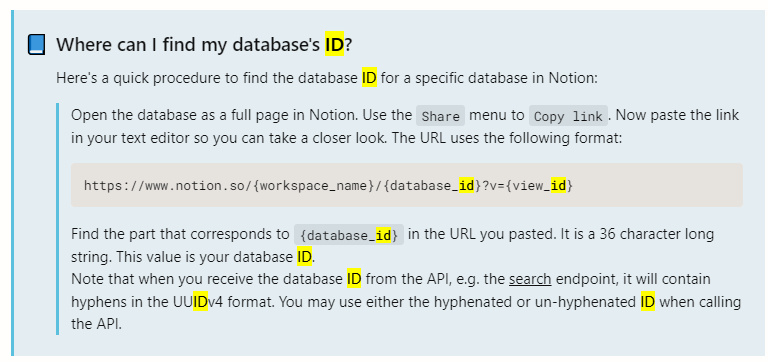
3. That's it! RUN ALL and paste the link to the problem!

In [ ]:
# Set your Notion API key
api_key = "your_secret_key_here"
# Set the database ID
database_id = 'database_id_here'

## paste the link here everytime you run

In [ ]:
leetcode_url = input()


https://leetcode.com/problems/rotate-image/description/


--------------------------------------------
# You don't have to modifiy anything below
--------------------------------------------

## extracting leetcode info

In [ ]:
def extract_leetcode_info(url):
    # Send a GET request to the provided URL
    response = requests.get(url)

    # Create a BeautifulSoup object to parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')
    # print(soup.prettify())
    
    # Extract the problem name
    # problem = soup.find('span', class_='mr-2').text.strip()
    problem_name = soup.find('title').text.split('-')[0]
    
    # Extract the problem number
    props_json = json.loads(soup.select("#__NEXT_DATA__")[0].text)
    problem_number = props_json["props"]["pageProps"]["dehydratedState"]["queries"][0]["state"]["data"]["question"]["questionFrontendId"]
    
    # Extract the problem description
    # Find the div containing the problem description
    description_div = soup.find_all('meta')[-3]["content"].split('?')[1]
    # Filter out paragraphs after the paragraph containing "<p>&nbsp;</p>"
    filtered_paragraphs = []
    for paragraph in description_div.split('\n'):
        if paragraph.split(' ')[0] == 'Example':
            break
        filtered_paragraphs.append(paragraph)

    # Join the filtered paragraphs into a single string
    problem_description = "\n".join(filtered_paragraphs)

    problem_difficulty = props_json["props"]["pageProps"]["dehydratedState"]["queries"][0]["state"]["data"]["question"]["difficulty"]

    # Return the extracted information as a dictionary
    return {
        'name': problem_name,
        'number': problem_number,
        'description': problem_description,
        'difficulty': problem_difficulty.lower(),
    }

In [ ]:
# Example usage
# leetcode_url = 'https://leetcode.com/problems/move-zeroes/description/'
info = extract_leetcode_info(leetcode_url)
problem_name = info['name']
problem_number = info['number']
problem_description = info['description']
problem_difficulty = info['difficulty']

print('Problem Name:', problem_name)
print('Problem Number:', problem_number)
print('Problem Description:', problem_description)
print('Problem Difficulty:', problem_difficulty)

## Notion API

In [ ]:

# Set the Notion API endpoint for retrieving a database
endpoint_database = f'https://api.notion.com/v1/databases/{database_id}'
endpoint_pages = f'https://api.notion.com/v1/pages'
endpoint_query = f'https://api.notion.com/v1/databases/{database_id}/query'
# Set the headers with the API key and content type
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
    'Notion-Version': '2022-06-28'
}

In [ ]:
exist = False
payload = {
    'filter': {
        'property': 'Problem',
        'number': {
            'equals': int(problem_number)
        }
    }
}
response = requests.post(endpoint_query.format(database_id=database_id), headers=headers, data=json.dumps(payload))
# Check the response status
if response.status_code == 200:
    # Get the response JSON data
    data = response.json()

    # Check if any results were found
    if data.get('results'):
        # A page with the specified problem number exists
        print('A page with the problem number exists.')
        exist = True
    else:
        # No page with the specified problem number exists
        print('No page with the problem number exists.')
else:
    # Query request failed
    print('Failed to query pages:', response.json())

In [ ]:

option_id = ''
color = ''
if problem_difficulty == 'Easy':
    option_id = 'iui['
    color = 'green'
elif problem_difficulty == 'Medium':
    option_id = 'Wk\t'
    color = 'purple'
elif problem_difficulty == 'Hard':
    option_id = 'D=mB'
    color = 'red'
# Set the properties of the new record
new_record = {
    'parent': {'database_id': database_id},
    'properties': {
        'Problem': {'number': int(problem_number)},
        'Name': {'title': [{'text': {'content': problem_name}}]},
        'Link': {'url': leetcode_url},
        'Difficulty': {
            'select' : {
                'name': problem_difficulty
            }
        }
    }
}


if not exist:
  # Send a POST request to create the new record
  response = requests.post(endpoint_pages, json=new_record, headers=headers)

  # Get the JSON response
  json_response = response.json()

  # Print the response
  # print(json_response)
  block_id = json_response['id']
else:
  print('A page with the problem number exists.')

In [ ]:
def heading_2(title):
    return  {
        'object': 'block',
        'type': 'heading_2',
        'heading_2': {
            'rich_text': [
                {
                    'type': 'text',
                    'text': {
                        'content': title,
                    }
                }
            ]
        }
    }
def paragraph(content):
    return  {
        'object': 'block',
        'type': 'paragraph',
        # 'paragraph': {'rich_text': [{'type': 'text', 'text': {'content': 'Implement a Queue by linked list. Support the following basic methods:', 'link': None},
        'paragraph': {
            'rich_text': [
                {
                    'type': 'text',
                    'text': {
                        'content': content,
                    }
                }
            ]
        }
    }


def code():
    return  {
        'object': 'block',
        'type': 'code',
        # 'paragraph': {'rich_text': [{'type': 'text', 'text': {'content': 'Implement a Queue by linked list. Support the following basic methods:', 'link': None},
        'code': {
            'caption': [
                {
                    'type': 'text',
                    'text': {
                        'content': 'O(N) time complexity',
                    }
                }
            ],
             'rich_text': [
                {
                    'type': 'text',
                    'text': {
                        'content': ''
                    }
                }
            ],
            'language': 'python'
        }
    }




In [ ]:
block_content = [

    heading_2("Problem"),
    paragraph(problem_description),
    heading_2("Discussion"),
    # paragraph("like in interview"),
    heading_2("Solution"),
    # paragraph("your solution here"),
    heading_2("Clarification & Difficulties"),
    # paragraph(" "),
    heading_2("Code"),
    code()


    # Add more blocks as needed
]

payload = {
    'children': block_content
}

if not exist:
  endpoint_page_children = f'https://api.notion.com/v1/blocks/{block_id}/children'
  response = requests.patch(endpoint_page_children, json=payload, headers=headers)

  # Get the JSON response
  json_response = response.json()

  # Print the response
  # print(json_response)
# else:
#   print('A page with the problem number exists.')

## result

In [ ]:
if not exist:
  # Print the response
  print(json_response)
else:
  print('A page with the problem number exists.')